# Vyřešená Úloha 2: Analýza nejlépe hodnocených žánrů

**Analytická otázka (v lidské řeči):**
Které jednotlivé filmové žánry jsou nejsilněji spojeny s vysokým diváckým hodnocením?

**Metodika:**
Použijeme proceduru `4ftMiner` z balíčku CleverMiner. Budeme hledat asociační pravidla typu:
**KDYŽ** `Žánr = X` **PAK** `Hodnocení = Vysoké`

Budeme hledat pouze ta pravidla, která jsou statisticky významná (nadprůměrná).

In [7]:
#importy
import pandas as pd
import ast, json
from cleverminer import cleverminer, clm_subset, clm_rcut  
from IPython.display import HTML, display
import io, contextlib,re
from IPython.core.interactiveshell import InteractiveShell   
import matplotlib.pyplot as plt




In [8]:
#Nastavení zobrazení výstupů
InteractiveShell.ast_node_interactivity = "all"   # ukaž všechny výstupy v buňce
pd.set_option("display.max_rows", None)           # nebo velké číslo místo None
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)


## 1. Příprava dat

Než můžeme analyzovat, musíme data připravit:
1.  Načteme `movies_metadata.csv`.
2.  Zpracujeme textový sloupec `genres`, který je ve formátu JSON, na seznam čistých názvů žánrů.
3.  Protože jeden film může mít více žánrů, musíme data "explodovat". Film se třemi žánry se tak v tabulce objeví třikrát (pro každý žánr jednou). To nám umožní analyzovat každý žánr samostatně.
4.  Spojitý atribut `vote_average` (hodnocení) diskretizujeme na tři stejně velké kategorie: `Low`, `Medium` a `High`.

In [9]:
df = pd.read_csv('movies_metadata.csv', low_memory=False)

# převod hodnocení na číslo
df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce')

# pomocná funkce pro parsování JSON ve sloupci "genres"
def try_literal_eval(x):
    if pd.isna(x):
        return []
    if isinstance(x, (list, dict)):
        return x
    try:
        return ast.literal_eval(x)
    except:
        try:
            return json.loads(x)
        except:
            return []

# převod žánrů na list názvů
df['genres'] = df['genres'].apply(try_literal_eval)
df['genres_list'] = df['genres'].apply(lambda lst: [d.get('name') for d in lst if isinstance(d, dict)])

# rozložení – každý film × žánr = 1 řádek
df = df.explode('genres_list').dropna(subset=['genres_list','vote_average']).copy()

# vytvoření kategorií hodnocení (Low / Medium / High)
df.loc[:, 'Rating_cat'] = pd.qcut(df['vote_average'], q=3, labels=['Low','Medium','High'])

# reset indexu (kvůli CleverMineru)
df = df.reset_index(drop=True)


## 2. Zadání úlohy (CleverMiner)

Nyní definujeme samotnou úlohu pro `4ftMiner`:

* **`df` (Data):** Použijeme pouze sloupce `genres_list` a `Rating_cat`.
* **`ante` (Antecedent/Předpoklad):** Hledáme jednotlivé žánry. `clm_subset('genres_list')` nám umožní testovat každý žánr (např. 'Animation', 'Drama' atd.) zvlášť.
* **`succ` (Succedent/Následek):** Hledáme pouze nejvyšší hodnocení. `clm_rcut('Rating_cat')` automaticky vybere poslední (tedy nejvyšší) kategorii, což je 'High'.
* **`quantifiers` (Kvantifikátory):** Chceme jen silná pravidla:
    * `Base: 200`: Pravidlo se musí vztahovat alespoň na 200 filmových záznamů.
    * `aad: 0.3`: Šance na vysoké hodnocení musí být alespoň o 30 % vyšší než průměr.

In [10]:
BASE_MIN = 200   # minimální velikost pravidla
AAD_MIN  = 0.3   # min. nadprůměrná odchylka

clm = cleverminer(
    df=df[['genres_list','Rating_cat']],   # jen potřebné sloupce
    proc='4ftMiner',
    quantifiers={'Base': BASE_MIN, 'aad': AAD_MIN},
    ante={'attributes':[clm_subset('genres_list')],
          'minlen':1,'maxlen':1,'type':'con'},
    succ={'attributes':[clm_rcut('Rating_cat')],
          'minlen':1,'maxlen':1,'type':'con'}
)

Cleverminer version 1.2.4.
Starting data preparation ...
Automatically reordering numeric categories ...
Automatically reordering numeric categories ...done
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  4ftMiner
Starting to mine rules.
  0%|                                                    |Elapsed Time: 0:00:00
100%|####################################################|Elapsed Time: 0:00:00
Done. Total verifications : 39, rules 5, times: prep 0.04sec, processing 0.06sec


/opt/homebrew/lib/python3.9/site-packages/cleverminer/cleverminer.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OO0000OOOO0O00O00 [O0OO0OO000O0OOOOO ]=OO0000OOOO0O00O00 [O0OO0OO000O0OOOOO ].apply (str )#line:395


## 3. Výsledky

Analýza našla 5 žánrů, které splnily naše přísné podmínky. Níže je jejich seznam a detailní statistiky.

* **CONF (Confidence):** Jistota. Např. `CONF: 0.517` u 'Documentary' znamená, že 51,7 % všech dokumentů v datech spadlo do kategorie 'High'.
* **AAD (Above Average Difference):** Klíčová metrika. `AAD: +0.638` znamená, že dokument má o 63,8 % vyšší pravděpodobnost vysokého hodnocení než náhodně vybraný filmový záznam.

In [11]:
buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    clm.print_summary()
    clm.print_rulelist()
txt = buf.getvalue()

# scrollovací zobrazení v notebooku



# zobrazení detailu 1. pravidla
clm.print_rule(1)
clm.print_rule(2)
clm.print_rule(3)
clm.print_rule(4)
clm.print_rule(5)




Rule id : 1

Base :   912  Relative base : 0.010  CONF : 0.472  AAD : +0.495  BAD : -0.495

Cedents:
  antecedent : genres_list(Animation)
  succcedent : Rating_cat(High)
  condition  : ---

Fourfold table
    |  S  |  ¬S |
----|-----|-----|
 A  |  912| 1022|
----|-----|-----|
¬A  |27810|61341|
----|-----|-----|



Rule id : 2

Base :  2031  Relative base : 0.022  CONF : 0.517  AAD : +0.638  BAD : -0.638

Cedents:
  antecedent : genres_list(Documentary)
  succcedent : Rating_cat(High)
  condition  : ---

Fourfold table
    |  S  |  ¬S |
----|-----|-----|
 A  | 2031| 1901|
----|-----|-----|
¬A  |26691|60462|
----|-----|-----|



Rule id : 3

Base :   668  Relative base : 0.007  CONF : 0.478  AAD : +0.515  BAD : -0.515

Cedents:
  antecedent : genres_list(History)
  succcedent : Rating_cat(High)
  condition  : ---

Fourfold table
    |  S  |  ¬S |
----|-----|-----|
 A  |  668|  730|
----|-----|-----|
¬A  |28054|61633|
----|-----|-----|



Rule id : 4

Base :   674  Relative base : 0.00

## 4. Závěr a Business Interpretace

Finální tabulka přehledně shrnuje náš objev.

**Slovní interpretace výsledků:**
Analýza jednoznačně ukázala, že nejlépe hodnocenými žánry jsou **Documentary** (Dokument) a **History** (Historický film). Šance, že dokument bude patřit do nejvyšší kategorie hodnocení, je o 63,8 % vyšší než u průměru.

**Business závěr:**
Pro producenty nebo distributory, kteří se zaměřují na kvalitu a vysoké divácké hodnocení (např. pro festivaly nebo specifické platformy), jsou dokumentární a historické filmy statisticky "sázkou na jistotu". Žánry jako 'Animation', 'War' a 'Music' jsou také nadprůměrné, ale jejich spojitost s nejvyšším hodnocením není tak silná.

,Žánr,CONF,AAD,AAD_txt
0,Documentary,0.517,0.638,+0.638
1,History,0.478,0.515,+0.515
2,Animation,0.472,0.495,+0.495
3,War,0.424,0.345,+0.345
4,Music,0.422,0.338,+0.338


<Figure size 800x500 with 0 Axes>

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Žánry s nadprůměrným hodnocením – AAD (Above Average Difference)')

Text(0.5, 0, 'AAD (relativní rozdíl vůči průměru)')

Text(0, 0.5, 'Žánr')

Text(0.34800000000000003, 0, '+0.338')

Text(0.355, 1, '+0.345')

Text(0.505, 2, '+0.495')

Text(0.525, 3, '+0.515')

Text(0.648, 4, '+0.638')

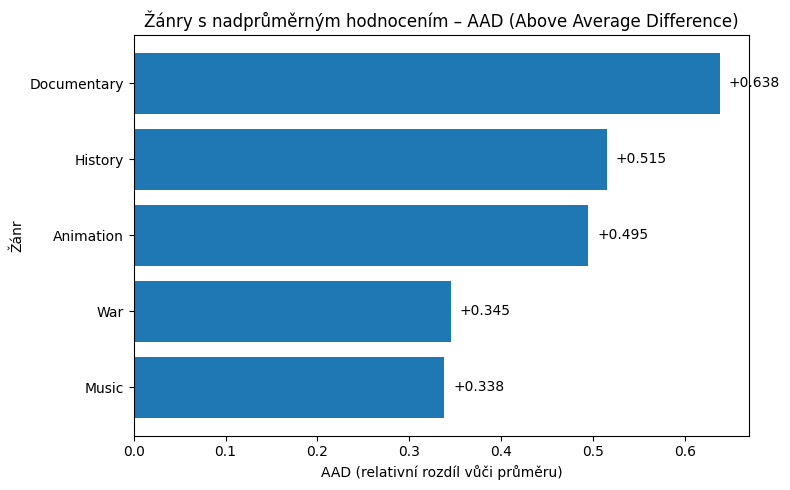

<Figure size 800x500 with 0 Axes>

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Pravděpodobnost vysokého hodnocení (CONF) podle žánru')

Text(0.5, 0, 'P(High | žánr)')

Text(0, 0.5, 'Žánr')

Text(0.432, 0, '0.422')

Text(0.434, 1, '0.424')

Text(0.482, 2, '0.472')

Text(0.488, 3, '0.478')

Text(0.527, 4, '0.517')

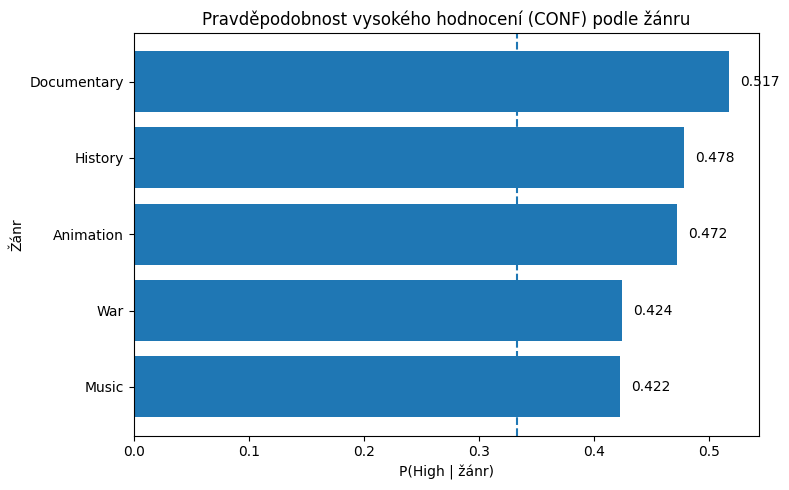

,Žánr,CONF,AAD,Význam
0,Documentary,0.517,0.638,výrazně nadprůměrné
1,History,0.478,0.515,výrazně nadprůměrné
2,Animation,0.472,0.495,velmi dobře hodnocené
3,War,0.424,0.345,mírně nadprůměrné
4,Music,0.422,0.338,mírně nadprůměrné


In [12]:

# 1) Naparsovat rulelist do DataFrame (Žánr, CONF, AAD)
def parse_rulelist_to_df(clm_obj):
    import io, contextlib
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        clm_obj.print_rulelist()
    txt = buf.getvalue()

    rows = []
    # očekávaný řádek: "…  CONF  AAD  genres_list(X) => Rating_cat(High) …"
    pat = re.compile(
        r"^\s*\d+\s+\d+\s+([0-9]*\.?[0-9]+)\s+([+\-]?[0-9]*\.?[0-9]+)\s+genres_list\(([^)]+)\)\s*=>\s*Rating_cat\(High\)",
        re.MULTILINE
    )
    for m in pat.finditer(txt):
        conf = float(m.group(1))
        aad_str = m.group(2)
        genre = m.group(3)
        try:
            aad_val = float(aad_str.replace("+",""))
        except:
            aad_val = float("nan")
        rows.append({"Žánr": genre, "CONF": conf, "AAD": aad_val, "AAD_txt": aad_str})
    return pd.DataFrame(rows)

df_rules = parse_rulelist_to_df(clm)

# Pokud je prázdné (např. kvůli filtrům), upozorni:
if df_rules.empty:
    display(HTML("<b> Nebyla nalezena žádná pravidla – snižte prosím BaseMin nebo aad.</b>"))
else:
    # Setřiď podle AAD a zobraz
    df_rules = df_rules.drop_duplicates(subset=["Žánr"]).sort_values(["AAD","CONF"], ascending=[False, False]).reset_index(drop=True)
    display(df_rules)

    # 2) Graf AAD (o kolik nad průměrem)
    plt.figure(figsize=(8, 5))
    df_plot_aad = df_rules.sort_values("AAD", ascending=True)
    plt.barh(df_plot_aad["Žánr"], df_plot_aad["AAD"])
    plt.title("Žánry s nadprůměrným hodnocením – AAD (Above Average Difference)")
    plt.xlabel("AAD (relativní rozdíl vůči průměru)")
    plt.ylabel("Žánr")
    # datové popisky
    for i, v in enumerate(df_plot_aad["AAD"]):
        plt.text(v + 0.01, i, f"+{v:.3f}", va='center')
    plt.tight_layout()
    plt.show()

    # 3) Graf CONF s baseline 1/3 (protože tercily)
    baseline = 1/3
    plt.figure(figsize=(8, 5))
    df_plot_conf = df_rules.sort_values("CONF", ascending=True)
    plt.barh(df_plot_conf["Žánr"], df_plot_conf["CONF"])
    plt.title("Pravděpodobnost vysokého hodnocení (CONF) podle žánru")
    plt.xlabel("P(High | žánr)")
    plt.ylabel("Žánr")
    # svislá čára baseline
    plt.axvline(baseline, linestyle='--')
    # datové popisky
    for i, v in enumerate(df_plot_conf["CONF"]):
        plt.text(v + 0.01, i, f"{v:.3f}", va='center')
    plt.tight_layout()
    plt.show()

    # 4) Varianta tabulky do prezentace (zaokrouhleno)
    df_present = df_rules.copy()
    df_present["CONF"] = df_present["CONF"].round(3)
    df_present["AAD"] = df_present["AAD"].round(3)
    df_present["Význam"] = df_present["AAD"].apply(
        lambda x: "výrazně nadprůměrné" if x >= 0.50 else "velmi dobře hodnocené" if x >= 0.40 else "mírně nadprůměrné" if x >= 0.30 else "—"
    )
    display(df_present[["Žánr","CONF","AAD","Význam"]])